# **Trabalho Final da disciplina de redes neurais**

Trabalho Final avaliativo da disciplina de Redes Neurais do curso de Engenharia Eletrônica e de Computação ministrada no período 2024.1 pelo professor Rogério Pinto Espindola.  

**Aluno**: Leonardo Fachetti Jovêncio

***`Para uma correta execução dos códigos aqui apresentados, alguns blocos devem ser execultados na ordem que aqui são apresentados. Por tanto, recomenda-se avaliar e execultar os códigos na sequência apresentada.`***


## **Importando as bibliotecas necessárias**

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import time

## **Baixando a base de dados escolhida**

A base de dados escolhida será baixada e importada para o ambiente de desenvolvimento como um objeto DataFrame com o nome `db`.

**Download da base de dados**

In [2]:
# A base de dados será salva no diretório atual de trabalho em um diretório denominado database

# Download da Base de dados do repositório UC Irvine
!wget "https://archive.ics.uci.edu/static/public/310/ujiindoorloc.zip"

# Descompactando o arquivo zip baixado
!unzip -q ujiindoorloc.zip
!mv UJIndoorLoc database
!rm *zip

--2024-07-20 17:56:52--  https://archive.ics.uci.edu/static/public/310/ujiindoorloc.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘ujiindoorloc.zip’

ujiindoorloc.zip        [   <=>              ]   1.40M  3.22MB/s    in 0.4s    

2024-07-20 17:56:53 (3.22 MB/s) - ‘ujiindoorloc.zip’ saved [1463759]



**Importando a base de dados no ambiente de desenvolvimento**



In [3]:
db_train = pd.read_csv ("database/trainingData.csv")
db_val = pd.read_csv ("database/validationData.csv")

# concatenando os dois databases em um só
db = pd.concat ([db_train, db_val]).reset_index(drop=True)

# Apagando os db antes da concatenação
del (db_train)
del (db_val)

# Exibindo a base de dados importada
print (db)

       WAP001  WAP002  WAP003  WAP004  WAP005  WAP006  WAP007  WAP008  WAP009  \
0         100     100     100     100     100     100     100     100     100   
1         100     100     100     100     100     100     100     100     100   
2         100     100     100     100     100     100     100     -97     100   
3         100     100     100     100     100     100     100     100     100   
4         100     100     100     100     100     100     100     100     100   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
21043     100     100     100     100     100     100     100     100     100   
21044     100     100     100     100     100     100     100     100     100   
21045     100     100     100     100     100     100     100     100     100   
21046     100     100     100     100     100     100     100     100     100   
21047     100     100     100     100     100     100     100     100     100   

       WAP010  ...  WAP520 

**Removendo algumas informações de localização da base de dados que não serão utilizadas**

In [4]:
# Elimando colunas que não serão utilizadas
colunas_excluir = ["BUILDINGID", "SPACEID", "RELATIVEPOSITION", "USERID", "PHONEID", "TIMESTAMP"]
db = db.drop (columns = colunas_excluir)

# Convertendo o atributo FLOOR para altitude (metros) -> 1 andar tem em torno 3,5 metros
db["FLOOR"] = db["FLOOR"] * 3.5
db.rename (columns = {"FLOOR": 'ALTITUDE'}, inplace=True)

# Exibindo base de dados final após a edição
print (db)

       WAP001  WAP002  WAP003  WAP004  WAP005  WAP006  WAP007  WAP008  WAP009  \
0         100     100     100     100     100     100     100     100     100   
1         100     100     100     100     100     100     100     100     100   
2         100     100     100     100     100     100     100     -97     100   
3         100     100     100     100     100     100     100     100     100   
4         100     100     100     100     100     100     100     100     100   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
21043     100     100     100     100     100     100     100     100     100   
21044     100     100     100     100     100     100     100     100     100   
21045     100     100     100     100     100     100     100     100     100   
21046     100     100     100     100     100     100     100     100     100   
21047     100     100     100     100     100     100     100     100     100   

       WAP010  ...  WAP514 

## **Desenvolvimento do sistema**

### **A. Preparação dos dados**

**Verificação de valores ausentes**

In [6]:
# A função isna ().sum () retorna a quantidade de valores ausentes em cada coluna da base de dados
print (db.isna().sum())

WAP001       0
WAP002       0
WAP003       0
WAP004       0
WAP005       0
            ..
WAP519       0
WAP520       0
LONGITUDE    0
LATITUDE     0
ALTITUDE     0
Length: 523, dtype: int64


**Verificação de outliers - gráficos boxplot**

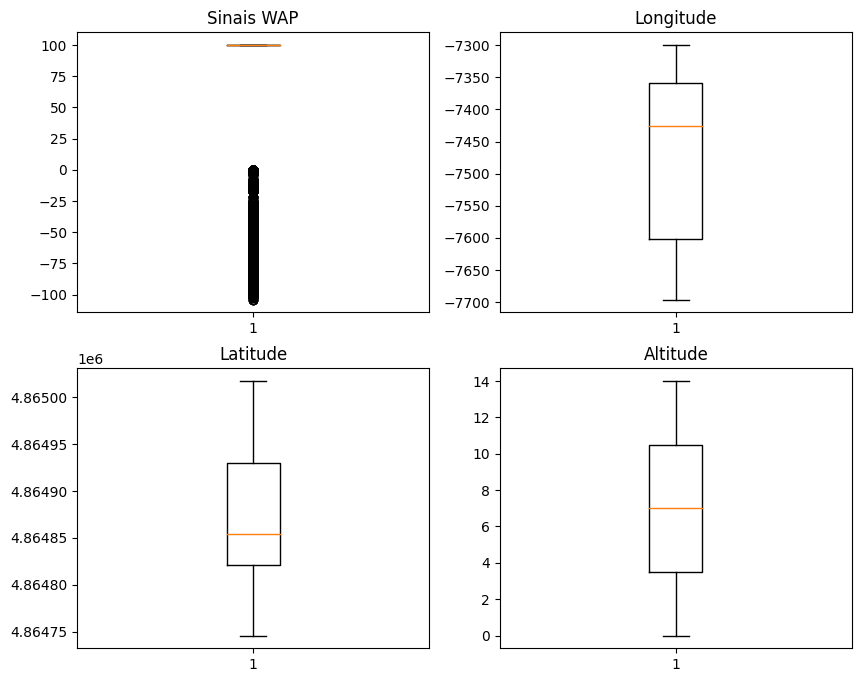

In [7]:
# Concatenando todas as intensidades do sinal Wi-Fi (atributo WAP) da base de dados em um único vetor
sinal_wifi = []

# Extraindo as intensidades do sinal Wi-Fi (atributo WAP) da base de dados
for i in range (1, 521):
    if (i < 10):
        sinal_wifi.append (db[f"WAP00{i}"])
    elif (10 <= i < 100):
        sinal_wifi.append (db[f"WAP0{i}"])
    else:
        sinal_wifi.append (db[f"WAP{i}"])

# Concatenando todas as intensidades WAP em uma única lista
sinal_wifi_concatenado = []
for s in sinal_wifi:
    sinal_wifi_concatenado.extend (s)

# Construindo os gráficos boxplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Sinais WAP
axs[0, 0].boxplot(pd.Series (sinal_wifi_concatenado))
axs[0, 0].set_title("Sinais WAP")

# Longitude
axs[0, 1].boxplot (list (db["LONGITUDE"]))
axs[0, 1].set_title("Longitude")

# Latitude
axs[1, 0].boxplot (list (db["LATITUDE"]))
axs[1, 0].set_title("Latitude")

# Altitude
axs[1, 1].boxplot (list (db["ALTITUDE"]))
axs[1, 1].set_title("Altitude")

plt.show()

**Realizando a padronização dos dados**

A base de dados padronizada será salva no objeto DataFrame chamado `db_padro`.

In [8]:
db_padro = db.copy () # base de dados padronizada

# Padronizando as entradas WAP utilizando a padronização valor máximo
for i in range (1, 521):
  if (i < 10):
    db_padro[f"WAP00{i}"] = db[f"WAP00{i}"]/100
  elif (i >= 10 and i < 100):
    db_padro[f"WAP0{i}"] = db[f"WAP0{i}"]/100
  else:
    db_padro[f"WAP{i}"] = db[f"WAP{i}"]/100

# Padronização das informações de localização utilizando a padronização gaussiana
db_padro["LONGITUDE"] = (db["LONGITUDE"] - db["LONGITUDE"].mean ()) / db["LONGITUDE"].std ()
db_padro["LATITUDE"] = (db["LATITUDE"] - db["LATITUDE"].mean ()) / db["LATITUDE"].std ()
db_padro["ALTITUDE"] = (db["ALTITUDE"] - db["ALTITUDE"].mean ()) / db["ALTITUDE"].std ()

### **B. Análise exploratória dos dados**

**Informações estatísticas acerca dos atributos da base de dados padronizada**

In [17]:
# Concatenando todas as intensidades do sinal Wi-Fi (atributo WAP) da base de dados padronizada em um único vetor
sinal_wifi_padro = []

# Extraindo as intensidades do sinal Wi-Fi (atributo WAP) da base de dados padronizada
for i in range (1, 521):
    if (i < 10):
        sinal_wifi_padro.append (db_padro[f"WAP00{i}"])
    elif (10 <= i < 100):
        sinal_wifi_padro.append (db_padro[f"WAP0{i}"])
    else:
        sinal_wifi_padro.append (db_padro[f"WAP{i}"])
sinal_wifi_padro_concatenado = []

for s in sinal_wifi_padro:
    sinal_wifi_padro_concatenado.extend (s)

# Entradas WAP
WAP_padro = pd.DataFrame (sinal_wifi_padro_concatenado, columns=["WAP"])
print ("WAP")
print (WAP_padro.describe())

# Longitude
print ("\nLongitude")
print (db_padro['LONGITUDE'].describe())

# Latitude
print ("\nLatitude")
print (db_padro['LATITUDE'].describe())

# Altitude
print ("\nAltitude")
print (db_padro['ALTITUDE'].describe())

WAP
                WAP
count  1.094496e+07
mean   9.385192e-01
std    3.263176e-01
min   -1.040000e+00
25%    1.000000e+00
50%    1.000000e+00
75%    1.000000e+00
max    1.000000e+00

Longitude
count    2.104800e+04
mean     7.561838e-15
std      1.000000e+00
min     -1.839354e+00
25%     -1.079208e+00
50%      3.388138e-01
75%      8.733673e-01
max      1.353237e+00
Name: LONGITUDE, dtype: float64

Latitude
count    2.104800e+04
mean    -2.030894e-14
std      1.000000e+00
min     -1.879093e+00
25%     -7.572238e-01
50%     -2.715066e-01
75%      8.571369e-01
max      2.146703e+00
Name: LATITUDE, dtype: float64

Altitude
count    2.104800e+04
mean     1.026249e-16
std      1.000000e+00
min     -1.376486e+00
25%     -5.518168e-01
50%      2.728523e-01
75%      1.097521e+00
max      1.922190e+00
Name: ALTITUDE, dtype: float64


**Histogramas dos dados padronizados**

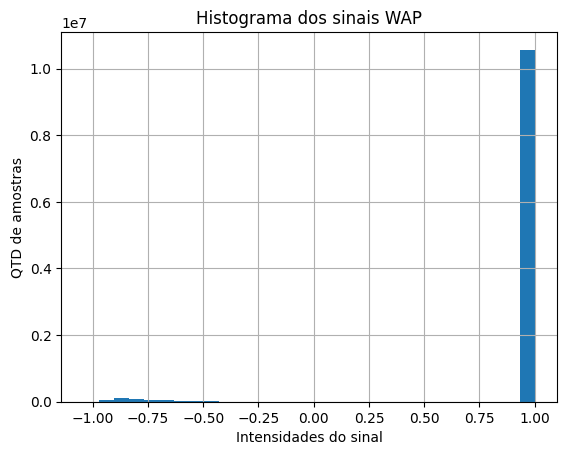

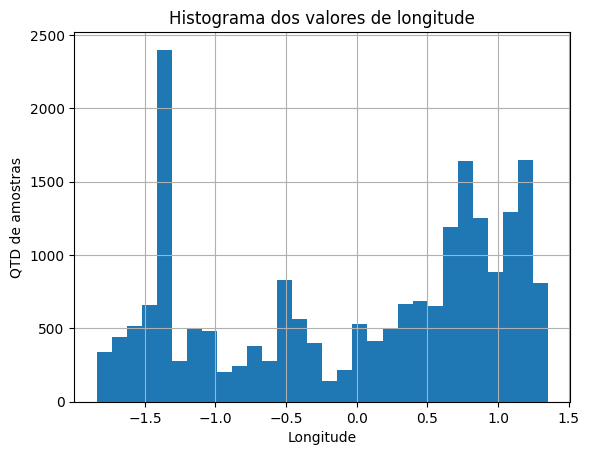

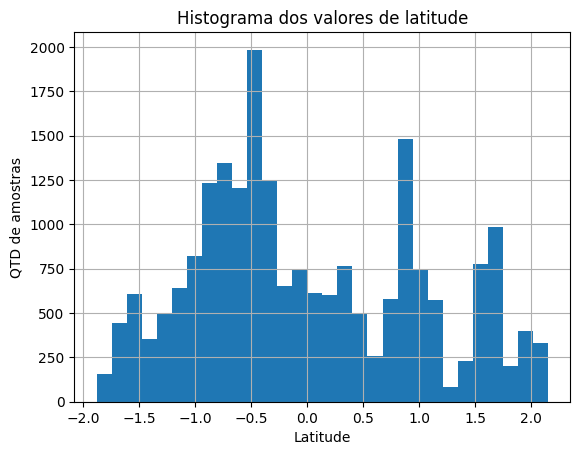

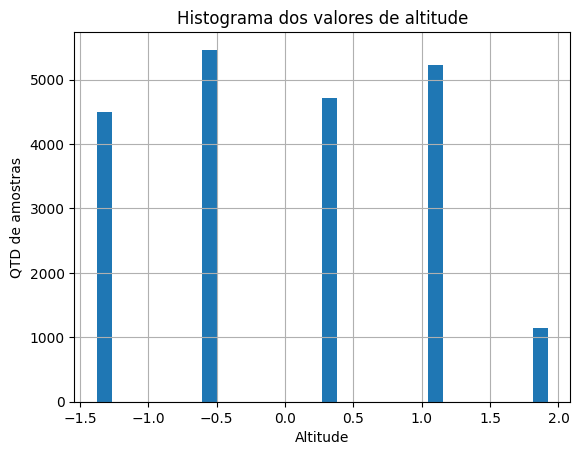

In [22]:
# Sinais WAP
plt.hist (WAP_padro, bins=30)
plt.title ("Histograma dos sinais WAP")
plt.xlabel ("Intensidades do sinal")
plt.ylabel ("QTD de amostras")
plt.grid ()
plt.show ()

# Longitude
plt.hist (db_padro['LONGITUDE'], bins=30)
plt.title ("Histograma dos valores de longitude")
plt.xlabel ("Longitude")
plt.ylabel ("QTD de amostras")
plt.grid ()
plt.show ()

# Latitude
plt.hist (db_padro['LATITUDE'], bins=30)
plt.title ("Histograma dos valores de latitude")
plt.xlabel ("Latitude")
plt.ylabel ("QTD de amostras")
plt.grid ()
plt.show ()

# Altitude
plt.hist (db_padro['ALTITUDE'], bins=30)
plt.title ("Histograma dos valores de altitude")
plt.xlabel ("Altitude")
plt.ylabel ("QTD de amostras")
plt.grid ()
plt.show ()

**Histograma das entradas WAP removendo os casos em que o sinal de Wi-Fi não é captado**

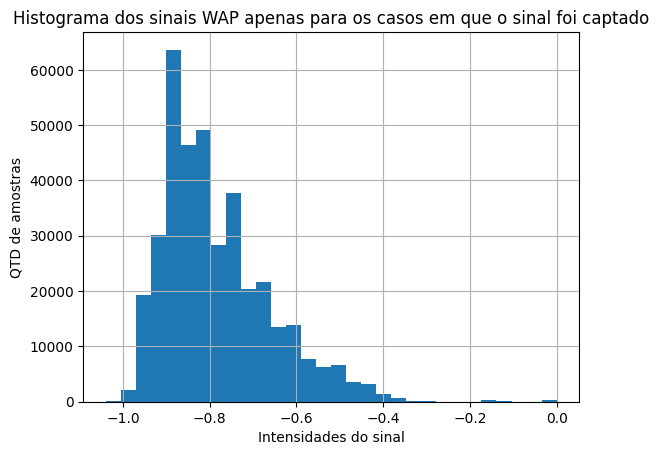

In [21]:
WAP_apenas_casos_captado = WAP_padro.loc[WAP_padro['WAP'] != 1]

# Sinais WAP nos casos em que o sinal foi captado
plt.hist (WAP_apenas_casos_captado, bins=30)
plt.title ("Histograma dos sinais WAP apenas para os casos em que o sinal foi captado")
plt.xlabel ("Intensidades do sinal")
plt.ylabel ("QTD de amostras")
plt.grid ()
plt.show ()

### **C. Modelagem da rede**

**Modelando a rede neural**

In [36]:
# Configurando alguns hiperparâmetros da rede
learning_rate = 0.001
num_epochs = 300

# Estrutura da rede neural
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(520, 256)   # 1 camada oculta
        self.layer2 = nn.Linear(256, 128)   # 2 camada oculta
        self.layer3 = nn.Linear(128, 64)    # 3 camada oculta
        self.output = nn.Linear(64, 3)      # Camada de saída
                                                # Saída 1 = Latitude
                                                # Saída 2 = Longitude
                                                # Saída 3 = Altitude

    def forward(self, x):
        x = torch.relu(self.layer1(x))  # ReLU na 1 camada oculta
        x = torch.relu(self.layer2(x))  # ReLU na 2 camada oculta
        x = torch.relu(self.layer3(x))  # ReLU na 3 camada oculta
        x = self.output(x)              # Sem função de ativação na camada de saída
        return x

# Inicializando o modelo, a função de perda e o otimizador
model = NeuralNetwork()
criterion = nn.MSELoss()  # Mean Squared Error para regressão
optimizer = optim.Adam(model.parameters(), learning_rate) # Adam (Adaptive Moment Estimation)

###**D. Treinamento da rede**

**Dividindo a base de dados para treinamento (70%), validação(15%) e teste(15%)**

In [12]:
# Dados a serem utilizados no processo de aprendizado
X = db_padro.drop (columns = ["LATITUDE", "LONGITUDE", "ALTITUDE"])
Y = db_padro[["LATITUDE", "LONGITUDE", "ALTITUDE"]]

# Dividindo os dados em treinamento, validação e teste na proporsão 70-15-15
'''Passo 1: Dividir em 70% para treinamento e 30% para um conjunto temporário'''
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.30, random_state=42)

'''Passo 2:  Dividir o conjunto temporário em 50% para validação e 50% para teste'''
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

# Verificando o tamanho dos conjuntos divididos
print (f"Tamanho da base de dados original: {db_padro.shape[0]} registros")
print(f"Tamanho do conjunto de treino: {X_train.shape[0]} registros => {(X_train.shape[0] / db_padro.shape[0])*100}%")
print(f"Tamanho do conjunto de validação: {X_val.shape[0]} registros => {(X_val.shape[0] / db_padro.shape[0])*100}%")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]} registros => {(X_test.shape[0] / db_padro.shape[0])*100}%")

# Convertendo os dados para tensores do PyTorch
X_train_tensor = torch.tensor (X_train.values, dtype=torch.float32)
Y_train_tensor = torch.tensor (Y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor (X_val.values, dtype=torch.float32)
Y_val_tensor = torch.tensor (Y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor (X_test.values, dtype=torch.float32)
Y_test_tensor = torch.tensor (Y_test.values, dtype=torch.float32)

# Criando os TensorDatasets
train_dataset = TensorDataset (X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset (X_val_tensor, Y_val_tensor)
test_dataset = TensorDataset (X_test_tensor, Y_test_tensor)

# Criando os DataLoaders
train_loader = DataLoader (train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader (val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader (test_dataset, batch_size=32, shuffle=False)

Tamanho da base de dados original: 21048 registros
Tamanho do conjunto de treino: 14733 registros => 69.99714937286203%
Tamanho do conjunto de validação: 3157 registros => 14.999049790954011%
Tamanho do conjunto de teste: 3158 registros => 15.003800836183961%


**Treinando a rede neural**

In [37]:
patience = 40  # Número de épocas para esperar antes de parar o treinamento antecipadamente caso não houver melhoria
best_loss_val = np.inf
patience_counter = 0
epoch_best_model = num_epochs

# Listas para armazenar os valores de erro
train_losses = []
val_losses = []

# Treinamento da rede
start = time.time()
for epoch in range(num_epochs):
    model.train()  # Modo de treinamento
    train_loss = 0.0
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()  # Zerar gradientes
        loss.backward()        # Computar gradientes
        optimizer.step()       # Atualizar os pesos
        train_loss += loss.item() * inputs.size(0)

    # Calcular erro médio do conjunto de treinamento
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Avaliação no conjunto de validação
    model.eval()  # Modo de avaliação
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)

        # Calcular erro médio do conjunto de validação
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

    # Verificando se houve melhoria
    if val_loss < best_loss_val:
        best_loss_val = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')  # Salvar o melhor modelo
        epoch_best_model = epoch
    else:
        patience_counter += 1

    # Se não houve melhoria, o aprendizado é interrompido antecipadamente
    if patience_counter >= patience:
        print(f'Parando treinamento antecipadamente na época {epoch+1}')
        break

    val_loss /= len(val_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Val Loss: {val_loss}')

end = time.time()
print("Treinamento concluído.")
print (f"Tempo gasto: {end - start} segundos")
print (f"Melhor modelo extraído da época {epoch_best_model}")

Epoch [1/300], Loss: 0.05756205692887306, Val Loss: 0.0006628745321610643
Epoch [2/300], Loss: 0.05350261926651001, Val Loss: 0.0006306415114248663
Epoch [3/300], Loss: 0.03784850984811783, Val Loss: 0.0004091697873571708
Epoch [4/300], Loss: 0.04771007224917412, Val Loss: 0.0005403958140246796
Epoch [5/300], Loss: 0.045924972742795944, Val Loss: 0.0003680517742005458
Epoch [6/300], Loss: 0.03550466522574425, Val Loss: 0.0003239594612616837
Epoch [7/300], Loss: 0.03524857759475708, Val Loss: 0.00037021501014342507
Epoch [8/300], Loss: 0.05119125172495842, Val Loss: 0.0003658969425124844
Epoch [9/300], Loss: 0.026760878041386604, Val Loss: 0.00033679715592480183
Epoch [10/300], Loss: 0.03808438032865524, Val Loss: 0.0005003603664885147
Epoch [11/300], Loss: 0.027165303006768227, Val Loss: 0.0003115319406164035
Epoch [12/300], Loss: 0.027034148573875427, Val Loss: 0.0003052886892883016
Epoch [13/300], Loss: 0.027589332312345505, Val Loss: 0.00028357851641512246
Epoch [14/300], Loss: 0.04

**Protando o gráfico da evolução do erro durante as épocas do aprendizado**

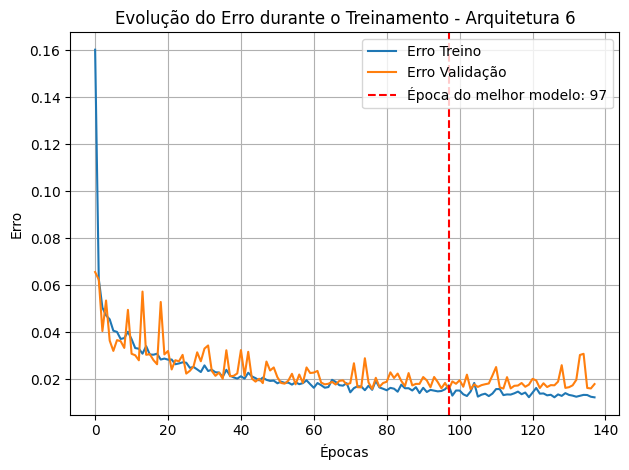

In [38]:
# Plotar o gráfico de erro
plt.plot(range(0, len (train_losses)), train_losses, label='Erro Treino')
plt.plot(range(0, len (val_losses)), val_losses, label='Erro Validação')
plt.axvline(x=epoch_best_model, color='r', linestyle='--', label=f'Época do melhor modelo: {epoch_best_model}')
plt.xlabel('Épocas')
plt.ylabel('Erro')
plt.title('Evolução do Erro durante o Treinamento - Arquitetura 6')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

###**E. Avaliando o desempenho da rede**

**Selecionando a arquitetura da rede desejada**

Deve ser informado, na variável `arquitetura_escolhida`, qual a arquitetura da rede que será avaliada.

In [117]:
arquitetura_escolhida = 6
print (f"Rede escolhida: {arquitetura_escolhida}")

# Saídas da rede
# Saída 1 = Latitude
# Saída 2 = Longitude
# Saída 3 = Altitude

# Arquitetura 1
if (arquitetura_escolhida == 1):
  class NeuralNetwork_1(nn.Module):
      def __init__(self):
          super(NeuralNetwork_1, self).__init__()
          self.layer1 = nn.Linear(520, 128)   # Camada oculta 1
          self.output = nn.Linear(128, 3)     # Camada de saída

      def forward(self, x):
          x = torch.relu(self.layer1(x))  # ReLU na camada oculta 1
          x = self.output(x)              # Sem função de ativação na camada de saída
          return x
  model = NeuralNetwork_1()

# Arquitetura 2
if (arquitetura_escolhida == 2):
  class NeuralNetwork_2(nn.Module):
      def __init__(self):
          super(NeuralNetwork_2, self).__init__()
          self.layer1 = nn.Linear(520, 256)   # Camada oculta 1
          self.output = nn.Linear(256, 3)     # Camada de saída

      def forward(self, x):
          x = torch.relu(self.layer1(x))  # ReLU na camada oculta 1
          x = self.output(x)              # Sem função de ativação na camada de saída
          return x
  model = NeuralNetwork_2()

# Arquitetura 3
if (arquitetura_escolhida == 3):
  class NeuralNetwork_3(nn.Module):
      def __init__(self):
          super(NeuralNetwork_3, self).__init__()
          self.layer1 = nn.Linear(520, 128)   # Camada oculta 1
          self.layer2 = nn.Linear(128, 64)    # Camada oculta 2
          self.output = nn.Linear(64, 3)      # Camada de saída

      def forward(self, x):
          x = torch.relu(self.layer1(x))  # ReLU na camada oculta 1
          x = torch.relu(self.layer2(x))  # ReLU na camada oculta 2
          x = self.output(x)              # Sem função de ativação na camada de saída
          return x
  model = NeuralNetwork_3()

# Arquitetura 4
if (arquitetura_escolhida == 4):
  class NeuralNetwork_4(nn.Module):
      def __init__(self):
          super(NeuralNetwork_4, self).__init__()
          self.layer1 = nn.Linear(520, 256)    # Camada oculta 1
          self.layer2 = nn.Linear(256, 128)    # Camada oculta 2
          self.output = nn.Linear(128, 3)      # Camada de saída

      def forward(self, x):
          x = torch.relu(self.layer1(x))  # ReLU na camada oculta 1
          x = torch.relu(self.layer2(x))  # ReLU na camada oculta 2
          x = self.output(x)              # Sem função de ativação na camada de saída
          return x
  model = NeuralNetwork_4()

# Arquitetura 5
if (arquitetura_escolhida == 5):
  class NeuralNetwork_5(nn.Module):
      def __init__(self):
          super(NeuralNetwork_5, self).__init__()
          self.layer1 = nn.Linear(520, 128)   # Camada oculta 1
          self.layer2 = nn.Linear(128, 64)    # Camada oculta 2
          self.layer3 = nn.Linear(64, 32)     # Camada oculta 3
          self.output = nn.Linear(32, 3)      # Camada de saída

      def forward(self, x):
          x = torch.relu(self.layer1(x))  # ReLU na camada oculta 1
          x = torch.relu(self.layer2(x))  # ReLU na camada oculta 2
          x = torch.relu(self.layer3(x))  # ReLU na camada oculta 3
          x = self.output(x)              # Sem função de ativação na camada de saída
          return x
  model = NeuralNetwork_5()

# Arquitetura 6
if (arquitetura_escolhida == 6):
  class NeuralNetwork_6(nn.Module):
      def __init__(self):
          super(NeuralNetwork_6, self).__init__()
          self.layer1 = nn.Linear(520, 256)   # Camada oculta 1
          self.layer2 = nn.Linear(256, 128)   # Camada oculta 2
          self.layer3 = nn.Linear(128, 64)    # Camada oculta 3
          self.output = nn.Linear(64, 3)      # Camada de saída

      def forward(self, x):
          x = torch.relu(self.layer1(x))  # ReLU na camada oculta 1
          x = torch.relu(self.layer2(x))  # ReLU na camada oculta 2
          x = torch.relu(self.layer3(x))  # ReLU na camada oculta 3
          x = self.output(x)              # Sem função de ativação na camada de saída
          return x
  model = NeuralNetwork_6()

Rede escolhida: 6


**Baixando os pesos dos melhores modelos salvos referente aos treinamentos realizados durante o trabalho e que foram salvos no github**

Os pesos serão baixados do github e um diretório chamada redes_neurais será criado no diretório de trabalho atual. Dentro do diretório redes_neurais estarão os pesos obtidos durante o processo de treinamento realizado no trabalho para cada uma das 6 arquiteturas propostas.

In [114]:
!git clone "https://github.com/leonardofach/redes_neurais.git"

Cloning into 'redes_neurais'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (8/8), 2.48 MiB | 18.37 MiB/s, done.


**Avaliando o desempenho da rede no conjunto de teste**

A arquitetura da rede deve ter sido escolhida anteriormente e armazenada na variável `arquitetura_escolhida`, pois, a partir dela, será instanciado a rede e escolhido o arquivo contendo os pesos.

In [119]:
# Selecionando o arquivo com os pesos da rede
pesos_file = f'redes_neurais/pesos_arquitetura_{arquitetura_escolhida}.pt'
model.load_state_dict(torch.load(pesos_file))

# Colocando o modelo em modo de avaliação
model.eval()

previsoes = []
valores_reais = []

with torch.no_grad():  # Desativar a computação de gradientes
  for batch in test_loader:
    inputs, targets = batch
    outputs = model(inputs)
    previsoes.append (outputs)
    valores_reais.append (targets)

# Concatenando listas em tensores
previsoes = torch.cat(previsoes)
valores_reais = torch.cat(valores_reais)

# Calculando o erro para cada uma das saídas individualmente - usando MSE
erro_latitude = 0
erro_longitude = 0
erro_altitude = 0

for i in range (0, len (previsoes)):
  erro_latitude += (previsoes[i][0] - valores_reais[i][0])**2
  erro_longitude += (previsoes[i][1] - valores_reais[i][1])**2
  erro_altitude += (previsoes[i][2] - valores_reais[i][2])**2

erro_latitude = erro_latitude / len (previsoes)
erro_longitude = erro_longitude / len (previsoes)
erro_altitude = erro_altitude / len (previsoes)

criterion = nn.MSELoss()
erro_rede = criterion (previsoes, valores_reais)

# Mostrando os erros médios
print(f'Erro saída latitude:  {erro_latitude}')
print(f'Erro saída longitude: {erro_longitude}')
print(f'Erro saída altitude:  {erro_altitude}')
print(f'Erro da rede:  {erro_rede.item()}')

Erro saída latitude:  0.013098018243908882
Erro saída longitude: 0.007144392468035221
Erro saída altitude:  0.02931610308587551
Erro da rede:  0.016519511118531227


**Calculando os erros percentuais da tabela 8 do relatório**

In [124]:
# Erros percentuais sobre os dados padronizados
erro_perc_latitude_padro = (erro_latitude / abs(db_padro['LATITUDE'].max() - db_padro['LATITUDE'].min()))*100
erro_perc_longitude_padro = (erro_longitude / abs(db_padro['LONGITUDE'].max() - db_padro['LONGITUDE'].min()))*100
erro_perc_altitude_padro = (erro_altitude / abs(db_padro['ALTITUDE'].max() - db_padro['ALTITUDE'].min()))*100

print (f"Latitude: {erro_perc_latitude_padro}")
print (f"Longitude: {erro_perc_longitude_padro}")
print (f"Altitude: {erro_perc_altitude_padro}")

Latitude: 0.3253522515296936
Longitude: 0.22378039360046387
Altitude: 0.8887232542037964
